# An Introductory Study on SF Crime Data

## Source and Purpose of the Analysis

The dataset was acquired from Kaggle [competition](https://www.kaggle.com/c/sf-crime). It portraits occurrances registered by SF Police department over 
the years of 2003-2015. The purpose of this analysis is to gain the first insights into crime occurence in San Francsico, CA districts. Additionaly a first attempt has been made to use machine learnig algorithms to predict crime incidents in terms of time and location. 

Such project could enable help & rescue teams, such as police, fire department and emergency medical services to prepare for upcoming events and better plan their work.

Statistical anlaysis concepts include:
 * Descriptive Statistics:
     * Summary statistics 
     * Exploratory Data Analysis with vizualizations
     * Time series analysis
 * Statistical Modeling/Machine Learning:
     * Random Forest Classifier
     * Naive Bayes

## Data

We consider the observations in data to be independent and identically distributed (i.i.d.). 

## Start


In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%pylab inline

from datetime import datetime


# Imports folium package and plugins
import folium
from folium import plugins
from folium.plugins import MarkerCluster

random.seed(1234)
sns.set(font_scale=1.5)

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.naive_bayes import MultinomialNB

Populating the interactive namespace from numpy and matplotlib


Loading the data:

In [2]:
df =pd.read_csv('train.csv')
df.head(3)

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414


Data contains numerical features, categorical features, and date feature. We check the data types to see if they correspond to the dataset metadata. 

In [3]:
# Checking data types in the data frame. 
df.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
Dates         878049 non-null object
Category      878049 non-null object
Descript      878049 non-null object
DayOfWeek     878049 non-null object
PdDistrict    878049 non-null object
Resolution    878049 non-null object
Address       878049 non-null object
X             878049 non-null float64
Y             878049 non-null float64
dtypes: float64(2), object(7)
memory usage: 60.3+ MB


Size of the dataset:

In [4]:
df.shape

(878049, 9)

There are around 878k events in the dataset. That seems to be more than enough to run an experiment on.

# Visualizing Crime Data in SF

In order to visualize the crime data geographocally, we choose the Folium's package. The tileset of choice is OpenStreetMap (which is default); however, Folium can be used with other tilesets like Mapbox or Cloudmade too.

As per Folium's documentation:

"Folium makes it easy to visualize data that’s been manipulated in Python on an interactive Leaflet map. It enables both the binding of data to a map for choropleth visualizations as well as passing Vincent/Vega visualizations as markers on the map."

[Folium Documentation]("https://pypi.python.org/pypi/folium")

Runnig the code below will create a map with location markers that are clustered if close together. The following data is for the first 100 entries of data.

In [100]:
SF_COORDINATES = [37.73, -122.40]

# creates an empty map zoomed in San Francisco
map = folium.Map(location=SF_COORDINATES, zoom_start=12)

# creates a marker cluster called "Crime cluster"
marker_cluster = folium.MarkerCluster("Crime Cluster").add_to(map) 

#add a marker for each event, add it to the cluster, not the map
for each in df[:500].iterrows(): # for speed purposes delimited data to 15K
    folium.Marker(location = [each[1]['Y'],each[1]['X']]).add_to(marker_cluster)
    
display(map)
# One can save a map as a html file by using map.create_map(path='map.html') 

# Data cleaning

The dataset contains time series data (Day of the Week, Date, Time),however the data type is not defined as so. We convert the date and time to separate columns of year, month and hour. We ignore the minutes and seconds.

#### Type casting the Dates column

In [5]:
def split_date(str_date):
    ''' This function splits the column "Date" in the SFPD into month, day and year. '''
    year = datetime.strptime(str_date, '%Y-%m-%d %H:%M:%S').year
    month = datetime.strptime(str_date, '%Y-%m-%d %H:%M:%S').month
    hour = datetime.strptime(str_date, '%Y-%m-%d %H:%M:%S').hour
    return int(year), int(month), int(hour) 

In [6]:
# Apply function to split date of each observation of date feature in the data set
df['year'] = df.Dates.apply(lambda x: split_date(x)[0])
df['month'] = df.Dates.apply(lambda x: split_date(x)[1])
df['hour'] = df.Dates.apply(lambda x: split_date(x)[2])

In [8]:
df.head(2)

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,year,month,hour
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,23
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,23


### Check for Missing Values

In [9]:
# Count for each feature
df.count()

Dates         878049
Category      878049
Descript      878049
DayOfWeek     878049
PdDistrict    878049
Resolution    878049
Address       878049
X             878049
Y             878049
year          878049
month         878049
hour          878049
dtype: int64

In [9]:
df.isnull().values.any()

False

# Exploratory Data Analysis

The events categories are divided into 39 unique classes:

In [10]:
df.Category.unique()

array(['WARRANTS', 'OTHER OFFENSES', 'LARCENY/THEFT', 'VEHICLE THEFT',
       'VANDALISM', 'NON-CRIMINAL', 'ROBBERY', 'ASSAULT', 'WEAPON LAWS',
       'BURGLARY', 'SUSPICIOUS OCC', 'DRUNKENNESS',
       'FORGERY/COUNTERFEITING', 'DRUG/NARCOTIC', 'STOLEN PROPERTY',
       'SECONDARY CODES', 'TRESPASS', 'MISSING PERSON', 'FRAUD',
       'KIDNAPPING', 'RUNAWAY', 'DRIVING UNDER THE INFLUENCE',
       'SEX OFFENSES FORCIBLE', 'PROSTITUTION', 'DISORDERLY CONDUCT',
       'ARSON', 'FAMILY OFFENSES', 'LIQUOR LAWS', 'BRIBERY',
       'EMBEZZLEMENT', 'SUICIDE', 'LOITERING', 'SEX OFFENSES NON FORCIBLE',
       'EXTORTION', 'GAMBLING', 'BAD CHECKS', 'TREA', 'RECOVERED VEHICLE',
       'PORNOGRAPHY/OBSCENE MAT'], dtype=object)

numbe of crimes in each year:

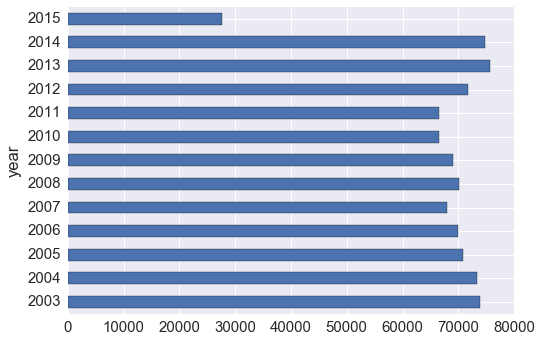

In [60]:
df.groupby('year').size().plot(kind='barh')
plt.show()

shows a significant reduction in 2015:

In [78]:
n_crimes = df.groupby('year').size()
print('2015 Reduction compared to 12 years average:')
(n_crimes.loc[2015]-n_crimes.mean())/n_crimes.mean()

2015 Reduction compared to 12 years average:


-0.59160365765464107

The above indicates small variation in the total number of crimes throughout the years.

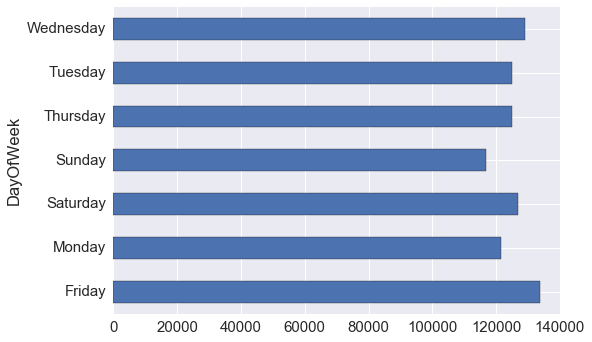

In [13]:
df.groupby('DayOfWeek').size().plot(kind='barh')
plt.show()

The same is true for distribution of crimes throught the week and months of the year.

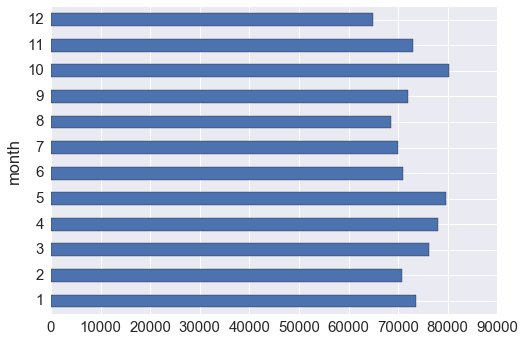

In [14]:
df.groupby('month').size().plot(kind='barh')
plt.show()

However the distribution of crimes throughout the hour of each day is not uniform. This suggests that the hour is 
likely to be a more effective feature for training.

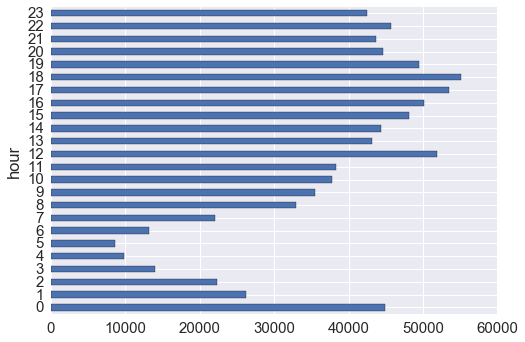

In [15]:
df.groupby('hour').size().plot(kind='barh')
plt.show()

## Class balance: 

It is important in a classification problem to pay attention to the distribution of classes in data. For a very imbalanced dataset it is unlikely to acheive a good model for all classes. As we can in see in the following the class distribution is highly imbalanced. That is why we will try to use oversampling in our training data.

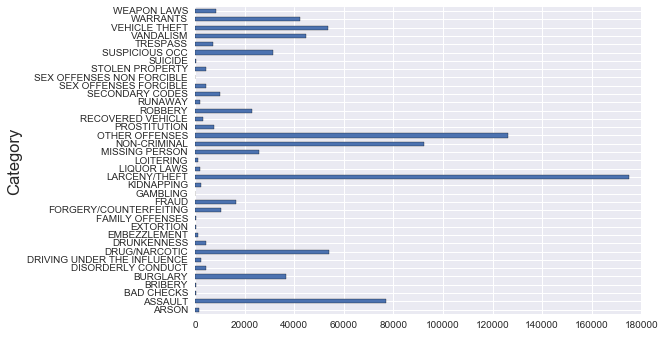

In [16]:
f = df.groupby('Category').size()
f[f > 100].plot(kind='barh')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

## Brief Time Series Analysis:

Here we tend to investigate whether any type of periodicity can be seen in the number of crimes as a function of time. We use a moving average method in which we average the number of crimes over a window of 6 month and plot data as a function of time:

In [41]:
df_ts = df[['Category','Dates']]

We separate the date from the Dates columns. We ignore the time (hour,minue and second).

In [86]:
df_ts['date'] = df_ts.Dates.apply(lambda x:datetime.strptime(x, '%Y-%m-%d %H:%M:%S').date())

In [44]:
df_ts.head(2)

,Category,Dates,date
137481,LARCENY/THEFT,2013-07-22 09:00:00,2013-07-22
718942,NON-CRIMINAL,2005-03-09 11:30:00,2005-03-09


In [45]:
df_ts_grouped = df_ts.groupby('date')

In [46]:
timeseries = df_ts_grouped.size()

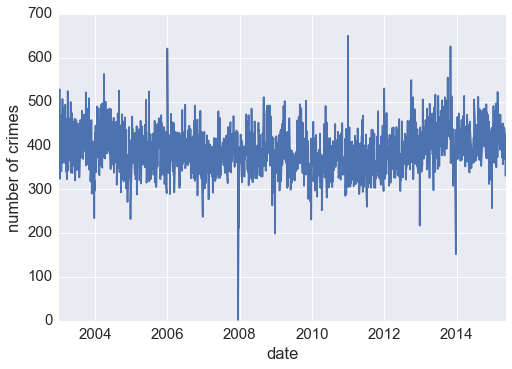

In [49]:
plt.plot(timeseries)
plt.xlabel('date')
plt.ylabel('number of crimes');

A first observation is that the number is staying in a window of 300 - 500 with the exception of 2008 and 2014.

In [53]:
rol_mean = timeseries.rolling(center=False, window=6).mean()
rol_std = timeseries.rolling(center=False, window=6).std()

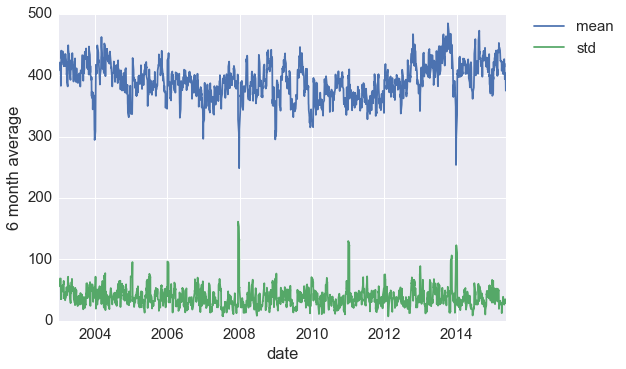

In [59]:
rol_mean.plot(label='mean')
rol_std.plot(label='std')
plt.ylabel('6 month average')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

From the above rolling average we do not see any significant mode of oscillation given the standar deviation. This analysis needs a further investigation into the modes of the oscillation and whether we can exctract beteer features from such time series in order to make a prediction. However the first impression is that the 6-month average number of crimes over the years of 2003-2015 has stayed between 300 to 500 with a standard deviation of less than 100.

## Classification

### Random Forest:

In a decision making process given the data, the random forest model classifies the crime category based on where the crime has happened in the past and at what time. Therefore a random forest seems appropriate to be a model for prediction. However for the SF crime data the performance has been poor:

In [7]:
# shuffle data:
df = df.sample(frac=1)

we do not use address, resolution, description. We only use district and the date (month, year and hour). 

In [89]:
X = df.drop(['Dates','Category','Descript','Resolution','Address',
            'DayOfWeek','X','Y'],axis=1)

In [90]:
X.head(2)

,PdDistrict,year,month,hour
137481,SOUTHERN,2013,7,9
718942,SOUTHERN,2005,3,11


In [91]:
y = list(df['Category'])

In [92]:
X_dumm = pd.get_dummies(X)

In [93]:
# train, test split:
X_train, X_test, y_train, y_test = train_test_split(X_dumm, y, test_size=0.4, random_state=42)

In [97]:
# obtaining the model performance (log loss) for various values of hyperparameter n_estimator:
logloss_rf = []
logloss_rf_train = []
for i in [20,40,60,120]:
    clf = RandomForestClassifier(n_estimators=i,n_jobs=-1)
    clf.fit(X_train,y_train)
    y_preds = clf.predict_proba(X_test)
    y_preds_train = clf.predict_proba(X_train)
    logloss_test = log_loss(y_pred=y_preds,y_true=y_test)
    logloss_train = log_loss(y_pred=y_preds_train,y_true=y_train)
    #print('log loss test:',logloss_test)
    #print('log loss train:',logloss_train)
    logloss_rf.append(logloss_test)
    logloss_rf_train.append(logloss_train)

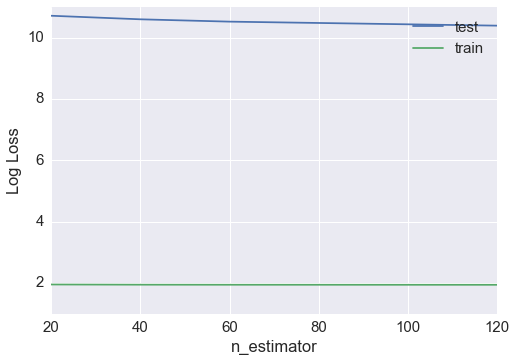

In [98]:
x = [20,40,60,120]
plt.plot(x,logloss_rf,label='test')
plt.plot(x,logloss_rf_train,label='train')
plt.xlabel('n_estimator')
plt.ylabel('Log Loss')
plt.legend();

As we can see in the above the logloss of train and test data may converge at higher values of estimators. Since the loss is much lower for train set it looks like the random forest is overfitting. However since the training loss (around 1.9) is still considered high this means the model has not been able to fit the data properly.

## Naive Bayes

Naive Bayes model is a model that tries to maximize the probability of crime category based on the assumption that the features (location and time of crime) are independent from each other. This model performs better than random forest in fact:

In [18]:
X = df.drop(['Dates','Category','Descript','Resolution','Address',
            'DayOfWeek','X','Y'],axis=1)

In [19]:
X_dumm = pd.get_dummies(X)

In [21]:
# train, test split:
X_train, X_test, y_train, y_test = train_test_split(X_dumm, y, test_size=0.4, random_state=42)

In [22]:
logloss_nb = []
logloss_nb_train = []
for alpha in np.linspace(0.1,1.0,20):
    clf = MultinomialNB(alpha=alpha)
    clf.fit(X_train,y_train)
    y_preds = clf.predict_proba(X_test)
    y_preds_train = clf.predict_proba(X_train)
    logloss_nb.append(log_loss(y_pred=y_preds,y_true=y_test))
    logloss_nb_train.append(log_loss(y_pred=y_preds_train,y_true=y_train))

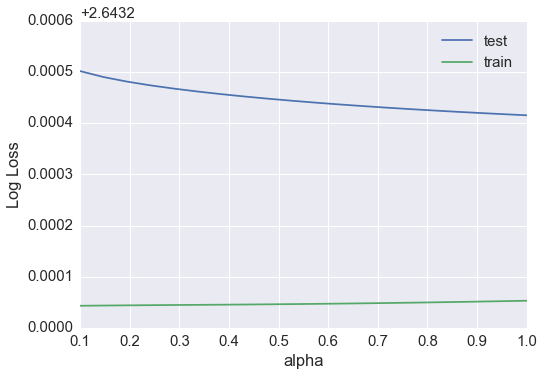

In [28]:
x = np.linspace(0.1,1.0,20)
plt.plot(x,logloss_nb,label='test')
plt.plot(x,logloss_nb_train,label='train')
plt.xlabel('alpha')
plt.ylabel('Log Loss')
plt.legend();

## Oversampling:

Here we investigate whether an oversampling method of training would improve the performance of the random forest model:

In [30]:
X = df.drop(['Dates','Category','Descript','Resolution','Address','year','month','hour',
            'DayOfWeek'],axis=1)

In [31]:
X_dumm = pd.get_dummies(X)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_dumm, y, test_size=0.4, random_state=42)

In [33]:
ros = RandomOverSampler(random_state=42)

In [34]:
X_ros,y_ros = ros.fit_sample(X_train,y_train)

In [35]:
clf = RandomForestClassifier(n_estimators=50,n_jobs=-1)

In [36]:
clf.fit(X_ros,y_ros)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [37]:
y_preds = clf.predict_proba(X_test)

In [38]:
log_loss(y_pred=y_preds,y_true=y_test)

7.5766309180061251

Over sampling for training purpose did not help in improving the random forest performance. This is perhaps indicating that the model itself is poor in generalizing the crime data.

## Conclusion:

Based on the descriptive statistics obtained from the SF crime data:

- The number of crimes has had a reduction from the past 12 years in 2015 by 59% which is significantly lowe than average.

- day of the week or the month in a year does not seem to show effect in crime variation.

- Hour of the day on the other hand shows significant variation with a significant drop at 5:00 AM.

- Crime type is at highest for THEFT while the least has happened for TREA. 

- The number of crimes is staying in a window of 300 - 500 with the exception of 2008 and 2014.

Random Forest does not perform well in predicting the crime category. Naive Bayes is performing better however it needs tuning.

Three more ideas here could be implemented in predicting the crime category:

- The time series analysis coule be performed based on separate districts. This may show a more understandable time variation and eventually a tool for prediction.

- Markov Chain: By creating a trasition matrix of crime percentage change from each year to the next year we may be able to make prediction in the probability of crime category occurence. This can be performed for each district separately. This assumes the number of crimes at each year is only dependent on the number of crime in the previous year.

- Memory learning (for example LSTM): Any recurrent model in which memory is included in the decision making could have a better performance. This is because the crime number as a social characteristic depends on the events in the past.

